<a href="https://colab.research.google.com/github/sydoky/Exercise-with-MobileNetV2-Architecture/blob/main/Exercise_with_MobileNetV2_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Getting results with 10% of the data
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-21 14:23:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   200MB/s    in 0.8s    

2022-05-21 14:23:19 (200 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
from IPython.core.display import Image
#Setting up the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_directory="10_food_classes_10_percent/train/"
test_directory="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent=train_datagen.flow_from_directory(train_directory,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Test Images: ")
test_data=train_datagen.flow_from_directory(test_directory,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Test Images: 
Found 2500 images belonging to 10 classes.


# **Preparing the dataset above. The next step is to build and fit the model**

In [5]:
#This step is called download the pretrained model 
# Resnet 50 V2 feature vector
import tensorflow_hub as hub
from tensorflow.keras import layers
mobile_net_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(mobile_net_v2,
                                          trainable=False, # freeze the underlying patterns
                                          input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

In [6]:
# Create our own model
model = tf.keras.Sequential([
  feature_extractor_layer, # use the feature extraction layer as the base
  layers.Dense(train_data_10_percent.num_classes, activation='softmax', name='output_layer') # create our own output layer      
])

# **Now I need to compile my model and after fit it**

In [7]:
#Compile Efficient Model
model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

#Fit Efficient Model
model=model.fit(train_data_10_percent,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data))
                

Epoch 1/5
24/24 [==============================] - 98s 4s/step - loss: 2.0152 - accuracy: 0.3387 - val_loss: 1.3395 - val_accuracy: 0.6056
Epoch 2/5
24/24 [==============================] - 93s 4s/step - loss: 1.0476 - accuracy: 0.7013 - val_loss: 0.9176 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 92s 4s/step - loss: 0.7317 - accuracy: 0.8000 - val_loss: 0.7606 - val_accuracy: 0.7708
Epoch 4/5
24/24 [==============================] - 93s 4s/step - loss: 0.5839 - accuracy: 0.8387 - val_loss: 0.6967 - val_accuracy: 0.7840
Epoch 5/5
24/24 [==============================] - 92s 4s/step - loss: 0.4842 - accuracy: 0.8707 - val_loss: 0.6803 - val_accuracy: 0.7728


# **We skip question #2**

In [8]:
#We are just checking how many pictures we have in the file 
import os
data_dir="/content/drive/MyDrive/CNN dataset"

for dirpath,dirnames,filenames in os.walk(data_dir):
  print("There are {} directories and {} images in {}".format(len(dirnames),len(filenames),dirpath))

There are 2 directories and 0 images in /content/drive/MyDrive/CNN dataset
There are 0 directories and 10 images in /content/drive/MyDrive/CNN dataset/dogs
There are 0 directories and 10 images in /content/drive/MyDrive/CNN dataset/cats


In [9]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               labels="inferred",
                                                               image_size=IMAGE_SHAPE,
                                                               batch_size=5)

Found 20 files belonging to 2 classes.


# Now we are going to visualize our photos 

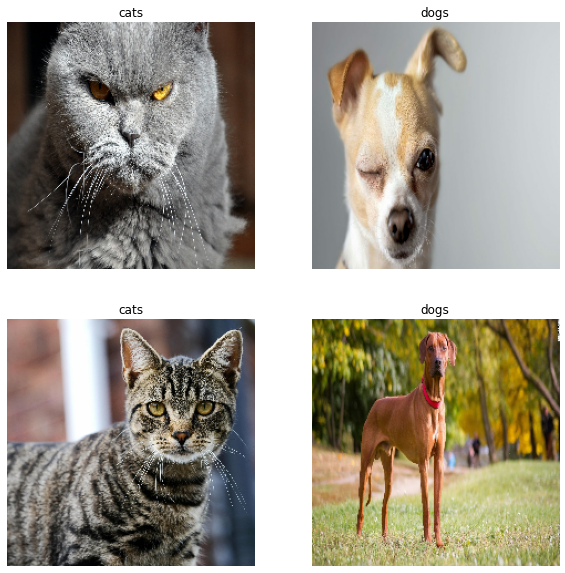

In [10]:
plt.figure(figsize=(10,10))
class_names=train_data.class_names
for images,labels in train_data.take(1):
  for i in range(4):
    ax=plt.subplot(2,2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Now we build a model that will be trained to classify which picture is**

In [11]:
model_2 = tf.keras.Sequential([
   feature_extractor_layer,
   layers.Dense(1, activation="sigmoid",name="output_layer")
])

In [14]:
#Now compile 
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                metrics=["accuracy"])

In [15]:
model_2_history=model_2.fit(train_data_10_percent,
                            epochs=15)

Epoch 1/15
24/24 [==============================] - 23s 892ms/step - loss: 0.4493 - accuracy: 0.8307
Epoch 2/15
24/24 [==============================] - 21s 886ms/step - loss: 0.3595 - accuracy: 0.9000
Epoch 3/15
24/24 [==============================] - 22s 901ms/step - loss: 0.3473 - accuracy: 0.9000
Epoch 4/15
24/24 [==============================] - 22s 898ms/step - loss: 0.3435 - accuracy: 0.9000
Epoch 5/15
24/24 [==============================] - 21s 884ms/step - loss: 0.3408 - accuracy: 0.9000
Epoch 6/15
24/24 [==============================] - 22s 894ms/step - loss: 0.3388 - accuracy: 0.9000
Epoch 7/15
24/24 [==============================] - 21s 884ms/step - loss: 0.3372 - accuracy: 0.9000
Epoch 8/15
24/24 [==============================] - 21s 890ms/step - loss: 0.3356 - accuracy: 0.9000
Epoch 9/15
24/24 [==============================] - 21s 878ms/step - loss: 0.3348 - accuracy: 0.9000
Epoch 10/15
24/24 [==============================] - 21s 882ms/step - loss: 0.3339 - accura

In [27]:
def plot_loss_curves(history):
  loss=history.history["loss"]
 
  accuracy=history.history["accuracy"]
  


  #Plot Loss function
  
  plt.plot(loss,label="training_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(accuracy,label="training_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

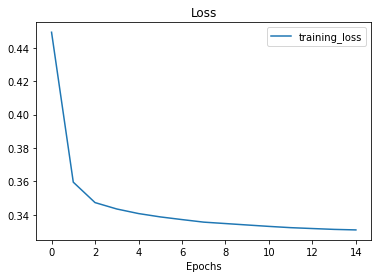

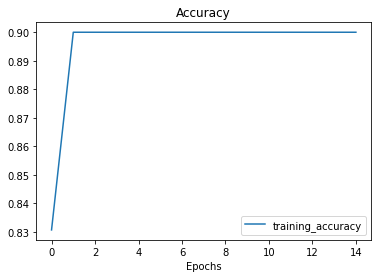

In [28]:
plot_loss_curves(model_2_history)